# Higgs Boson Challenge: Ridge regression

In this notebook, we use the training dataset to compute the accuracy score of the ridge regression algorithm. We use polynomial expansion with the parameters obtained by cross validation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Import methods from scripts/
from path import add_src_to_path, load_json_parameters, DATA_TRAIN_PATH

# Add src/ to path to import functions
add_src_to_path()

# Import functions from src/
from clean_data import clean_train_test_data_by_jet, get_columns_to_remove_by_jet
from cross_validation import build_poly
from csv_utils import load_csv_data
from helpers import predict_labels
from implementations import ridge_regression
from metrics import accuracy_score, confusion_matrix, get_proportions
from plot_utils import plot_accuracies, plot_confusion_matrix, plot_counts
from print_utils import (get_subset_label, print_shapes, print_shapes_by_jet,
                         print_subset_label, NB_SUBSETS)
from split_data import split_by_jet, split_train_test, NB_SUBSETS

In [3]:
# Load data
y, x, ids = load_csv_data(DATA_TRAIN_PATH)
print_shapes(y, x)

Shape of y: (250000,)
Shape of x: (250000, 30)


## Data exploration

We show the proportions of labels in the dataset and in the subsets.

Proportions: {-1: 0.657332, 1: 0.342668}


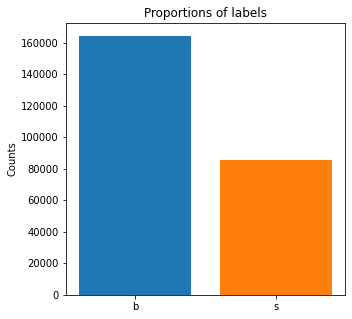

In [4]:
# Get proportions
proportions = get_proportions(y)
print('Proportions:', proportions)

# Plot counts
plot_counts(y, title='Proportions of labels')

In [5]:
# Split the data by jet
y_by_jet, x_by_jet, _ = split_by_jet(y, x, ids)
print_shapes_by_jet(y_by_jet, x_by_jet)

JET = 0:
Shape of y: (99913,)
Shape of x: (99913, 29)
JET = 1:
Shape of y: (77544,)
Shape of x: (77544, 29)
JET >= 2:
Shape of y: (72543,)
Shape of x: (72543, 29)


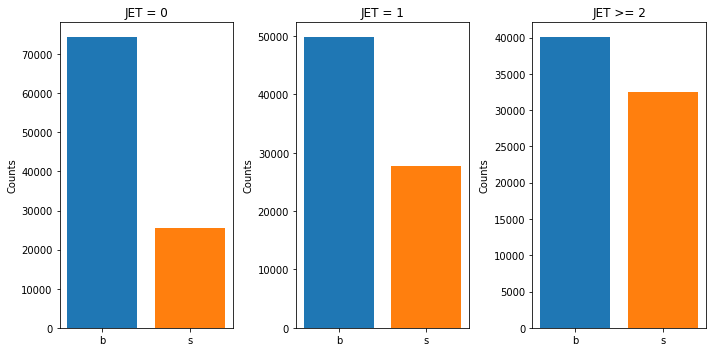

In [6]:
# Plot counts
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
for i in range(NB_SUBSETS):
    plot_counts(y_by_jet[i], get_subset_label(i), axs[i])
plt.tight_layout()

We check the columns to remove for each subset.

In [7]:
# Get columns to remove for each subset
cols_to_remove = get_columns_to_remove_by_jet(y_by_jet, x_by_jet)
for i in range(NB_SUBSETS):
    print(get_subset_label(i))
    print(cols_to_remove[i])

JET = 0
[ 4  5  6 12 22 23 24 25 26 27 28]
JET = 1
[ 4  5  6 12 25 26 27]
JET >= 2
[]


## Data splitting

In [8]:
# Split data train test
x_tr, x_te, y_tr, y_te = split_train_test(y, x)
print('Train:')
print_shapes(y_tr, x_tr)
print('Test:')
print_shapes(y_te, x_te)

Train:
Shape of y: (200000,)
Shape of x: (200000, 30)
Test:
Shape of y: (50000,)
Shape of x: (50000, 30)


In [9]:
# Split train data by jet
y_tr_by_jet, x_tr_by_jet, _ = split_by_jet(y_tr, x_tr)
print_shapes_by_jet(y_tr_by_jet, x_tr_by_jet)

JET = 0:
Shape of y: (79923,)
Shape of x: (79923, 29)
JET = 1:
Shape of y: (61985,)
Shape of x: (61985, 29)
JET >= 2:
Shape of y: (58092,)
Shape of x: (58092, 29)


In [10]:
# Split test data by jet
y_te_by_jet, x_te_by_jet, _ = split_by_jet(y_te, x_te)
print_shapes_by_jet(y_te_by_jet, x_te_by_jet)

JET = 0:
Shape of y: (19990,)
Shape of x: (19990, 29)
JET = 1:
Shape of y: (15559,)
Shape of x: (15559, 29)
JET >= 2:
Shape of y: (14451,)
Shape of x: (14451, 29)


## Data cleaning

In [11]:
# Clean train and test data by jet
y_tr_by_jet, x_tr_by_jet, y_te_by_jet, x_te_by_jet = clean_train_test_data_by_jet(
    y_tr_by_jet, x_tr_by_jet, y_te_by_jet, x_te_by_jet
)

In [12]:
# Shape of train data
print_shapes_by_jet(y_tr_by_jet, x_tr_by_jet)

JET = 0:
Shape of y: (79923,)
Shape of x: (79923, 18)
JET = 1:
Shape of y: (61985,)
Shape of x: (61985, 22)
JET >= 2:
Shape of y: (58092,)
Shape of x: (58092, 29)


In [13]:
# Shape of test data
print_shapes_by_jet(y_te_by_jet, x_te_by_jet)

JET = 0:
Shape of y: (19990,)
Shape of x: (19990, 18)
JET = 1:
Shape of y: (15559,)
Shape of x: (15559, 22)
JET >= 2:
Shape of y: (14451,)
Shape of x: (14451, 29)


## Load parameters

In [14]:
# Load parameters
params = load_json_parameters()
lambdas = params['ridge_regression']['lambda_']
degrees = params['ridge_regression']['degree']
print('Lambda by subset:', lambdas)
print('Degree by subset:', degrees)

Lambda by subset: [0.001, 0.001, 0.001]
Degree by subset: [13, 14, 13]


## Run algorithm

We run the ridge regression algorithm with polynomial expansion on each subset.

In [15]:
# Run ridge regression
w_by_jet = list()

for i in range(NB_SUBSETS):
    print_subset_label(i)

    # Get train subset
    x_tr_jet, y_tr_jet = x_tr_by_jet[i], y_tr_by_jet[i]

    # Build polynomial basis
    phi_tr_jet = build_poly(x_tr_jet, degrees[i])

    # Run ridge regression
    w, loss = ridge_regression(y_tr_jet, phi_tr_jet, lambdas[i], verbose=True)

    # Add weights to list
    w_by_jet.append(w)

JET = 0:
Loss: 0.228
JET = 1:
Loss: 0.282
JET >= 2:
Loss: 0.250


## Predictions

We predict the labels of each testing subset.

In [16]:
# Predict test data by jet
y_pred_by_jet = list()
accuracies = list()
conf_matrices = list()

for i in range(NB_SUBSETS):
    # Get subset
    x_te_jet, y_te_jet, w = x_te_by_jet[i], y_te_by_jet[i], w_by_jet[i]

    # Build polynomial basis
    phi_te_jet = build_poly(x_te_jet, degrees[i])

    # Predict labels
    y_pred = predict_labels(w, phi_te_jet)
    y_pred_by_jet.append(y_pred)

    # Accuracy score
    accuracy = accuracy_score(y_te_jet, y_pred)
    accuracies.append(accuracy)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_te_jet, y_pred)
    conf_matrices.append(conf_matrix)

We concatenate the predictions.

Accuracy = 0.82834


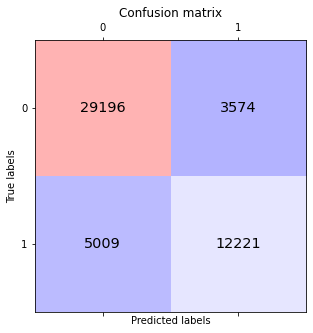

In [17]:
# Concatenate results
y_te = np.concatenate(y_te_by_jet)
y_pred = np.concatenate(y_pred_by_jet)

# Global accuracy
global_accuracy = accuracy_score(y_te, y_pred)
print('Accuracy =', global_accuracy)

# Global confusion matrix
global_conf_matrix = confusion_matrix(y_te, y_pred)
plot_confusion_matrix(global_conf_matrix)

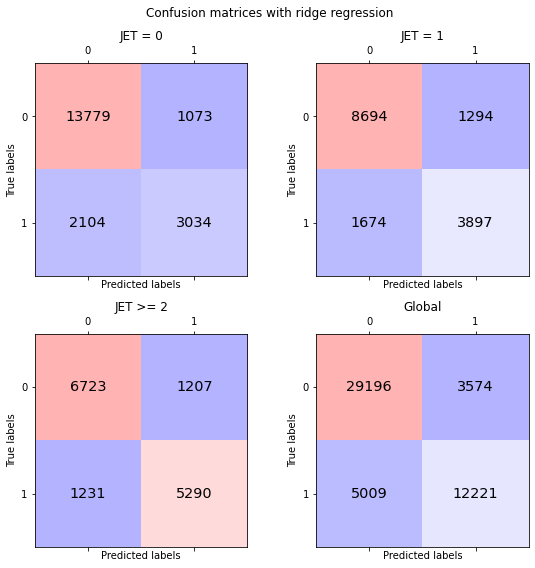

In [18]:
# Plot confusion matrices
plt.figure(figsize=(8, 8))

# Plot subset matrices
for i in range(NB_SUBSETS):
    ax = plt.subplot(2, 2, i + 1)
    plot_confusion_matrix(conf_matrices[i], ax=ax, title=get_subset_label(i))

# Plot global matrix
ax = plt.subplot(2, 2, 4)
plot_confusion_matrix(global_conf_matrix, ax=ax, title='Global')

plt.suptitle('Confusion matrices with ridge regression')
plt.tight_layout()

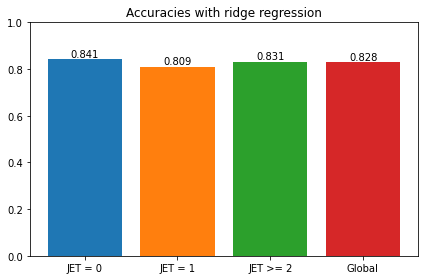

In [19]:
# Plot accuracies
plot_accuracies(accuracies + [global_accuracy],
                title='Accuracies with ridge regression')
plt.tight_layout()